<a href="https://colab.research.google.com/github/AnLiMan/CNN-for-audio-recognition/blob/main/Emergency_vehicle_siren_sounds_v_0_4_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Настройки сети

In [ ]:
number_of_interations = 1
print('Текущий номер для сохранения модели, чекпоинтов, а также загрузки существующей модели с облака: ', number_of_interations)

Текущий номер для сохранения модели, чекпоинтов, а также загрузки существующей модели с облака:  1


#Библиотеки



In [ ]:
import zipfile
import os
from google.colab import drive
import IPython
import numpy as np
import matplotlib.pyplot as plt 

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from __future__ import absolute_import, division, print_function, unicode_literals
import time

!pip install -q pyyaml h5py  # Требуется для сохранения модели в формате HDF5

#Подключение гугл диска и загрузка данных

In [ ]:
drive.mount('/content/drive')
zip_file1 = '/content/drive/My Drive/Files for colab/CNN for audio/Emergency_Vehicle_Siren_Sounds.zip'
zip_file2 = '/content/drive/My Drive/Files for colab//CNN for audio/spectrograms2.zip'
z1 = zipfile.ZipFile(zip_file1, 'r')
z1.extractall()
z2 = zipfile.ZipFile(zip_file2, 'r')
z2.extractall()
print(os.listdir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<built-in function listdir>


Проверим файлы

In [ ]:
media_path1 = "sounds/ambulance/sound_1.wav"
print('ambulance')
IPython.display.Audio(media_path1)

ambulance


In [ ]:
media_path2 = "sounds/firetruck/sound_201.wav"
print('firetruck')
IPython.display.Audio(media_path2)

firetruck


In [ ]:
media_path3 = "sounds/traffic/sound_401.wav"
print('traffic')
IPython.display.Audio(media_path3)

traffic


#Подготовка загруженных данных

In [ ]:
#перед этим создайте папку с данными train и в папке train создайте еще шесть папок для шести дефектов
import shutil
import numpy as np

try:
    source1 = "spectrograms/train"
    os.mkdir("spectrograms/test")
    dest11 = "spectrograms/test"
    files = os.listdir(source1)

    for f in files:
        os.mkdir(dest11 + '/'+ f)
        spilt_num = int(len(os.listdir(source1 + '/'+ f))*0.08)
        for i in os.listdir(source1 + '/'+ f)[spilt_num:]:
            shutil.move(source1 + '/'+ f +'/'+ i, dest11 + '/'+ f +'/'+ i)
except:
    print("\nВсе уже есть в каталоге. Вам не нужно запускать эту ячейку")


Все уже есть в каталоге. Вам не нужно запускать эту ячейку


In [ ]:
import shutil
import numpy as np

try:
    source1 = "spectrograms/test"
    os.mkdir("spectrograms/valid")
    dest11 = "spectrograms/valid"
    files = os.listdir(source1)

    for f in files:
        os.mkdir(dest11 + '/'+ f)
        spilt_num=int(len(os.listdir(source1 + '/'+ f))*0.5)
        for i in os.listdir(source1 + '/'+ f)[spilt_num:]:
            shutil.move(source1 + '/'+ f +'/'+ i, dest11 + '/'+ f +'/'+ i)
except:
    print("\nВсе уже есть в каталоге. Вам не нужно запускать эту ячейку")


Все уже есть в каталоге. Вам не нужно запускать эту ячейку


Подгонка изображений для нейросети (масштаб от 0 до 1), а также их группировка по пакетам 

In [ ]:
# Все изображения будут смасштабированы к 1./255
train_datagen = ImageDataGenerator(rescale = 1. / 255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Обучающие изображения партиями по 10 с использованием генератора train_datagen
train_generator = train_datagen.flow_from_directory('spectrograms/train', target_size = (84, 84), batch_size = 10, class_mode = 'categorical')

# Тестовая выборка по 10 пакетов с использованием генератора train_datagen
validation_generator = test_datagen.flow_from_directory('spectrograms/valid', target_size = (84, 84), batch_size = 10, class_mode = 'categorical')

Found 540 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


Класс колбека, останавливающий процесс обучения, если была достигнута необходимая точность

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.92 ):
            print("\nТочность расчёта более 93%, расчёт был остановлен!")
            self.model.stop_training = True 

#Определение модели нейросети и её компиляция

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, (2,2), activation='relu', input_shape=(84, 84, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
print('Модель свёрточной сети создана')
model.summary()

Модель свёрточной сети создана
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 83, 83, 8)         104       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 41, 41, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 40, 40, 32)        1056      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 20, 20, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 19, 19, 64)        8256      
                                                                 
 max_pooling2d_14 (MaxP

#Обучение нейросети

In [ ]:
callbacks = myCallback()
checkpoint_path = "/content/drive/My Drive/Files for colab/CNN for audio/Checkpoint_" + str(number_of_interations) + ".ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Создаем коллбек сохраняющий веса модели
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, save_weights_only = True, verbose = 1)
history = model.fit(train_generator, batch_size = 10, epochs = 15, validation_data = validation_generator, callbacks=[cp_callback], verbose = 1, shuffle = True)
# Сохраним всю модель в  HDF5 файл
model.save("/content/drive/My Drive/Files for colab/CNN for audio/CNN_model_" + str(number_of_interations) + ".h5")

Epoch 1/15
53/54 [============================>.] - ETA: 0s - loss: 1.0685 - accuracy: 0.4208
Epoch 00001: saving model to /content/drive/My Drive/Files for colab/CNN for audio/Checkpoint_1.ckpt
54/54 [==============================] - 5s 82ms/step - loss: 1.0668 - accuracy: 0.4204 - val_loss: 0.8823 - val_accuracy: 0.5000
Epoch 2/15
54/54 [==============================] - ETA: 0s - loss: 0.7897 - accuracy: 0.6593
Epoch 00002: saving model to /content/drive/My Drive/Files for colab/CNN for audio/Checkpoint_1.ckpt
54/54 [==============================] - 4s 76ms/step - loss: 0.7897 - accuracy: 0.6593 - val_loss: 1.1558 - val_accuracy: 0.3333
Epoch 3/15
54/54 [==============================] - ETA: 0s - loss: 0.6031 - accuracy: 0.7630
Epoch 00003: saving model to /content/drive/My Drive/Files for colab/CNN for audio/Checkpoint_1.ckpt
54/54 [==============================] - 4s 78ms/step - loss: 0.6031 - accuracy: 0.7630 - val_loss: 0.5972 - val_accuracy: 0.6000
Epoch 4/15
53/54 [=======

#Построение результатов обучения и проверка работоспособности

##Графики процесса обучения

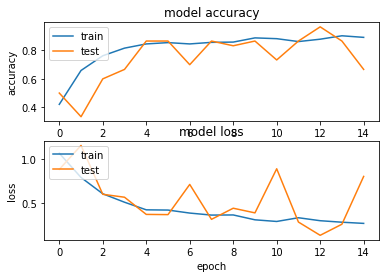

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(1)  

# обобщение истории для точности   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # обобщение истории для потерь    
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

##Загрузка сохранённой модели

In [ ]:
# Восстановим в точности ту же модель, включая веса и оптимизатор
Loading_model = keras.models.load_model("/content/drive/My Drive/Files for colab/CNN for audio/CNN_model_" + str(number_of_interations) + ".h5")
Loading_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 83, 83, 8)         104       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 41, 41, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 40, 40, 32)        1056      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 20, 20, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 19, 19, 64)        8256      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 9, 9, 64)        

##Подготовка данныъх

In [ ]:
# Загрузим имена файлов и их соответствующие целевые метки в массив numpy
from sklearn.datasets import load_files
import numpy as np

test_dir = 'spectrograms/test'

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
x_test, y_test,target_labels = load_dataset(test_dir)

In [ ]:
no_of_classes = len(np.unique(y_test))
print('Количество классов: ', no_of_classes)

Количество классов:  3


In [ ]:
from keras.utils import np_utils
y_test = np_utils.to_categorical(y_test,no_of_classes)

In [ ]:
# У нас есть только имена файлов в наборе x. Загрузим изображения и преобразуем их в массив.
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Преобразование в массив Numpy
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

x_test = np.array(convert_image_to_array(x_test))
print('Размеры тестовой выборки (кол-во изображений, размеры, кол-во каналов): ', x_test.shape)

Размеры тестовой выборки (кол-во изображений, размеры, кол-во каналов):  (60, 84, 84, 3)


In [ ]:
x_test = x_test.astype('float32')/255

##Проверка работоспособности

###16 случайных спектрограмм

Время выполнения операции =  0.20093894004821777  c


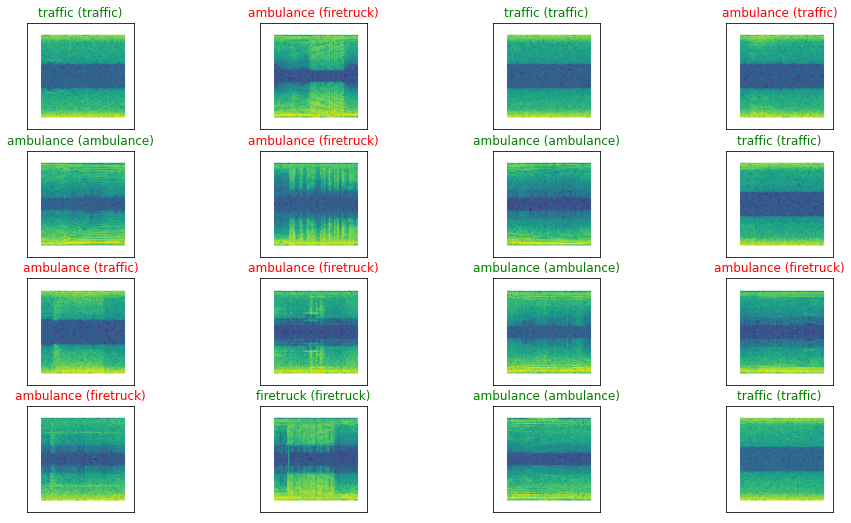

In [ ]:
import matplotlib.pyplot as plt

y_pred = Loading_model.predict(x_test)
start_time = time.time()
# построение случайной выборки тестовых изображений, их предсказанные метки и  истинного значения
fig = plt.figure(figsize = (16, 9))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size = 16, replace = False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]), color = ("green" if pred_idx == true_idx else "red"))

print("Время выполнения операции = ", (time.time() - start_time), ' c')

###Проверка отдельного изображения из тестовой выборки с расчётом затраченного времени

Введите номер изображения, для теста из тестовой выборки (от 0 до 59)
16
Время выполнения операции =  0.015292644500732422  c


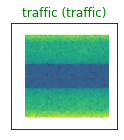

In [ ]:
import matplotlib.pyplot as plt

print('Введите номер изображения, для теста из тестовой выборки (от 0 до 59)')
idx = int(input())

start_time = time.time()
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
ax.imshow(np.squeeze(x_test[idx]))
pred_idx = np.argmax(y_pred[idx])
true_idx = np.argmax(y_test[idx])
ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]), color=("green" if pred_idx == true_idx else "red"))
print("Время выполнения операции = ", (time.time() - start_time), ' c')

###Прогонка всей тестовой выборки

Прогон всех тестовых изображений по порядку


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


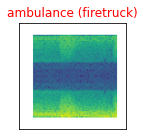

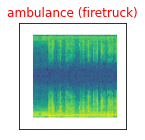

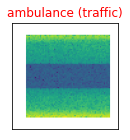

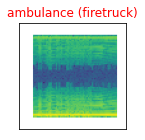

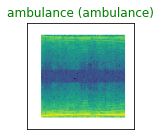

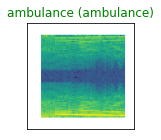

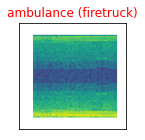

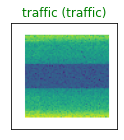

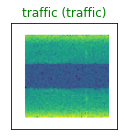

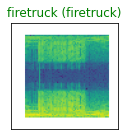

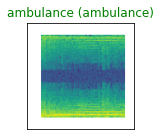

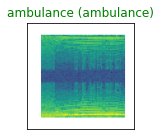

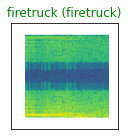

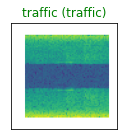

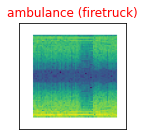

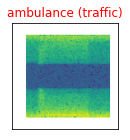

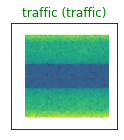

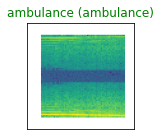

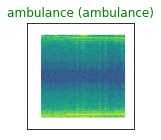

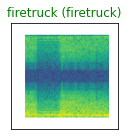

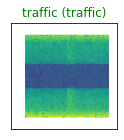

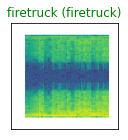

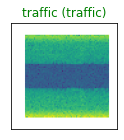

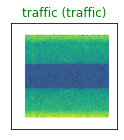

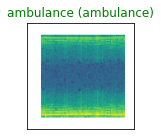

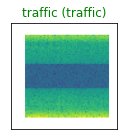

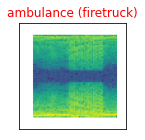

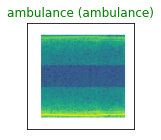

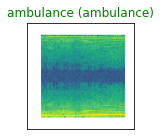

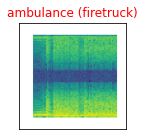

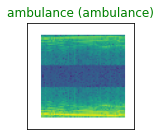

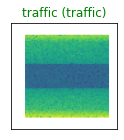

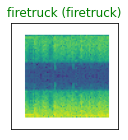

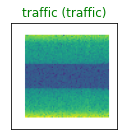

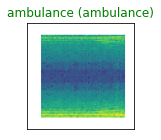

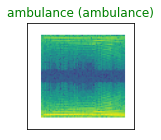

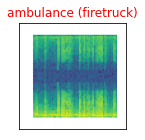

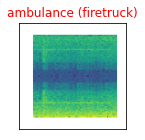

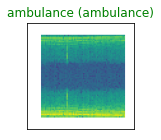

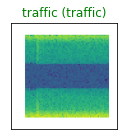

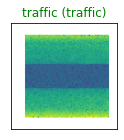

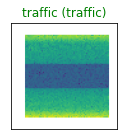

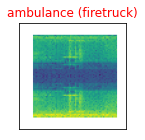

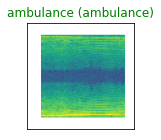

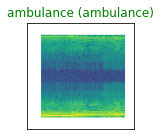

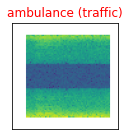

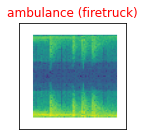

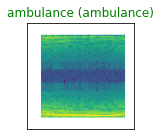

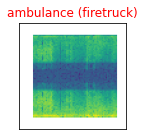

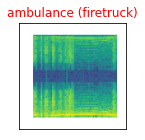

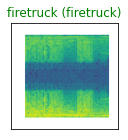

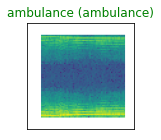

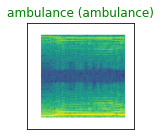

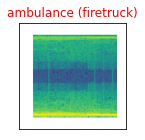

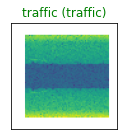

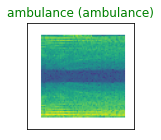

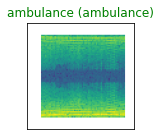

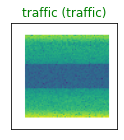

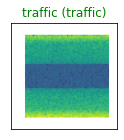

In [ ]:
import matplotlib.pyplot as plt

print('Прогон всех тестовых изображений по порядку')

for k in range(59):

  fig = plt.figure(figsize=(16, 9))
  ax = fig.add_subplot(4, 4, 2, xticks=[], yticks=[])
  ax.imshow(np.squeeze(x_test[k]))
  pred_idx = np.argmax(y_pred[k])
  true_idx = np.argmax(y_test[k])
  ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]), color=("green" if pred_idx == true_idx else "red"))

###Проверка отдельного изображения из тестовой выборки с расчётом затраченного времени без вывода изображения

In [ ]:
print('Введите номер изображения, для теста из тестовой выборки (от 0 до 59)')
idx = int(input())

start_time = time.time()
pred_idx = np.argmax(y_pred[idx])
print('Номер дефекта: ', pred_idx)
print("Время выполнения операции = ", (time.time() - start_time), ' c')
time_for_operation = (time.time() - start_time)
print("Расшифровка: ambulance = 0, firetruck = 1, traffic = 2")

Введите номер изображения, для теста из тестовой выборки (от 0 до 59)
16
Номер дефекта:  2
Время выполнения операции =  0.00119781494140625  c
Расшифровка: ambulance = 0, firetruck = 1, traffic = 2
